In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
from models import VGG16

import os
from tqdm import tqdm

/jun/anaconda3/envs/abaw1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vgg16 = VGG16(num_classes=88, use_pretrain=True)

In [3]:
# 데이터셋 경로 설정
dataset_train_path = os.path.join("mvtec_anomaly_detection_imagefolder", "train")
dataset_validation_path = os.path.join("mvtec_anomaly_detection_imagefolder", "validation")

# 이미지 변환 설정
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 데이터셋의 평균과 표준편차 사용
                                ])

# 데이터셋 로드
train_dataset = torchvision.datasets.ImageFolder(root=dataset_train_path, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root=dataset_validation_path, transform=transform)

# 데이터 로더 설정
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# VGG16 모델 불러오기
# vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16 = VGG16(num_classes=88, use_pretrain=True)

# GPU를 사용할 수 있는 경우 GPU로 모델을 이동합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

# 손실 함수 및 최적화기 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)


In [4]:
train_dataset.classes

['bottle-broken_large',
 'bottle-broken_small',
 'bottle-contamination',
 'bottle-good',
 'cable-bent_wire',
 'cable-cable_swap',
 'cable-combined',
 'cable-cut_inner_insulation',
 'cable-cut_outer_insulation',
 'cable-good',
 'cable-missing_cable',
 'cable-missing_wire',
 'cable-poke_insulation',
 'capsule-crack',
 'capsule-faulty_imprint',
 'capsule-good',
 'capsule-poke',
 'capsule-scratch',
 'capsule-squeeze',
 'carpet-color',
 'carpet-cut',
 'carpet-good',
 'carpet-hole',
 'carpet-metal_contamination',
 'carpet-thread',
 'grid-bent',
 'grid-broken',
 'grid-glue',
 'grid-good',
 'grid-metal_contamination',
 'grid-thread',
 'hazelnut-crack',
 'hazelnut-cut',
 'hazelnut-good',
 'hazelnut-hole',
 'hazelnut-print',
 'leather-color',
 'leather-cut',
 'leather-fold',
 'leather-glue',
 'leather-good',
 'leather-poke',
 'metal_nut-bent',
 'metal_nut-color',
 'metal_nut-flip',
 'metal_nut-good',
 'metal_nut-scratch',
 'pill-color',
 'pill-combined',
 'pill-contamination',
 'pill-crack',
 'p

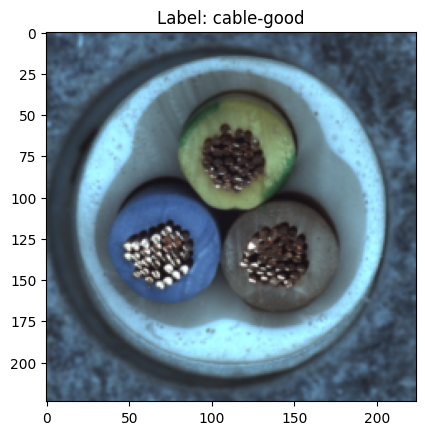

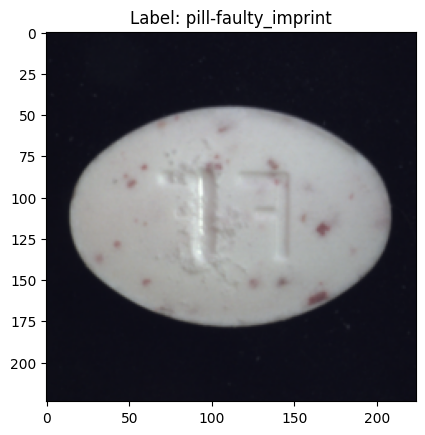

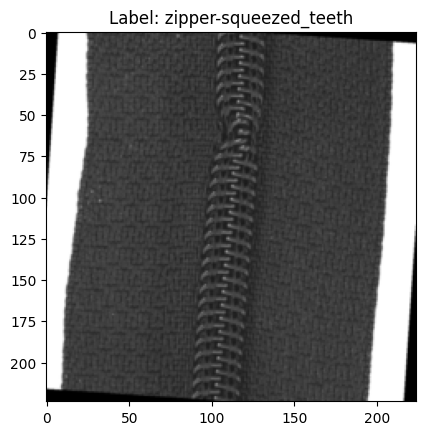

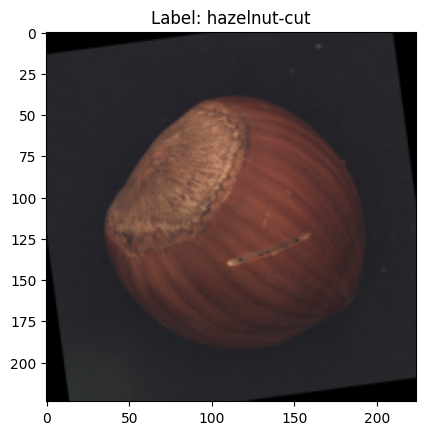

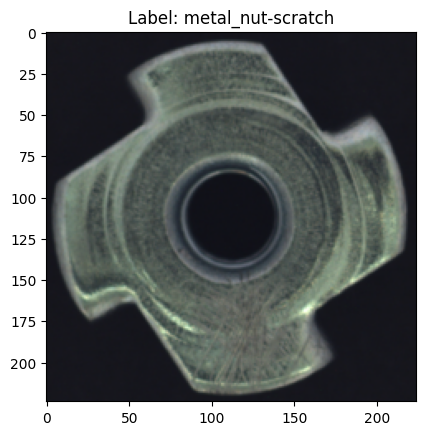

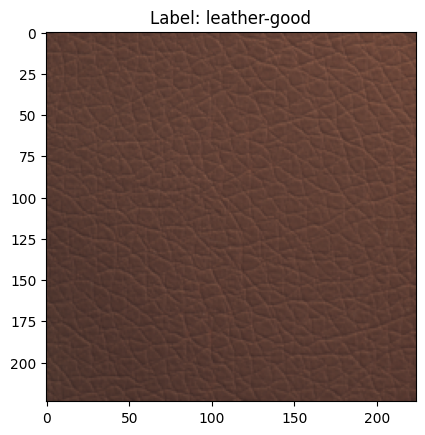

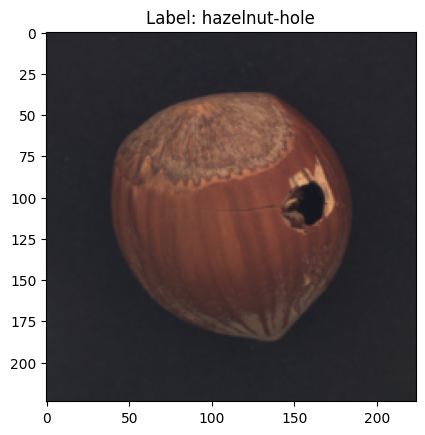

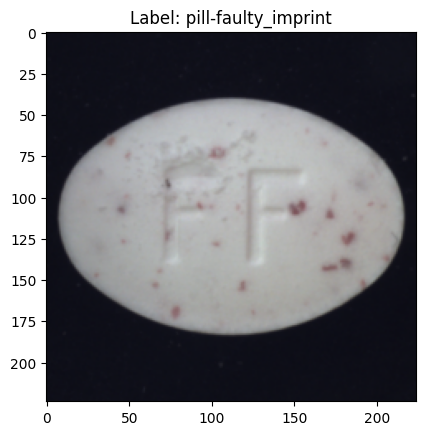

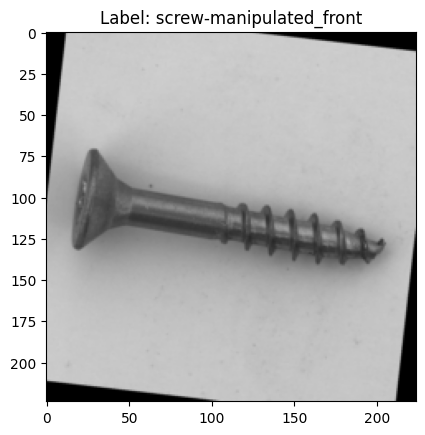

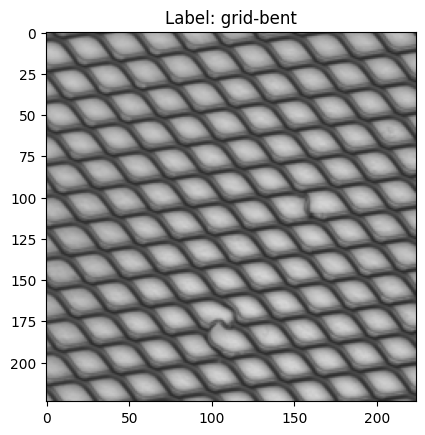

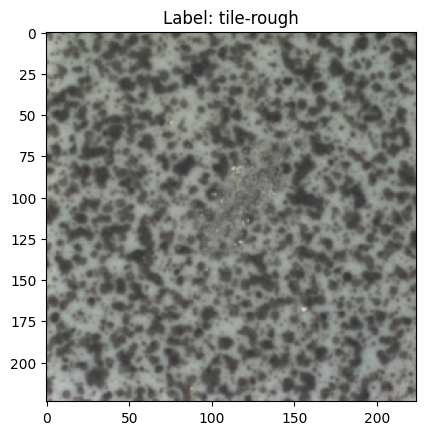

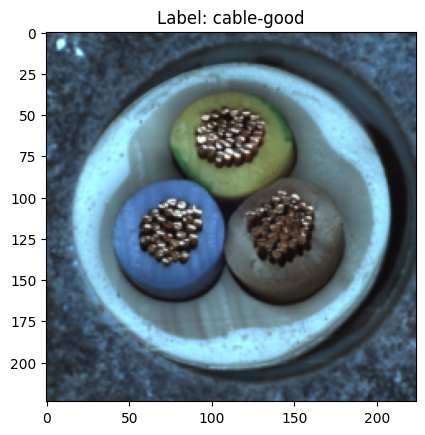

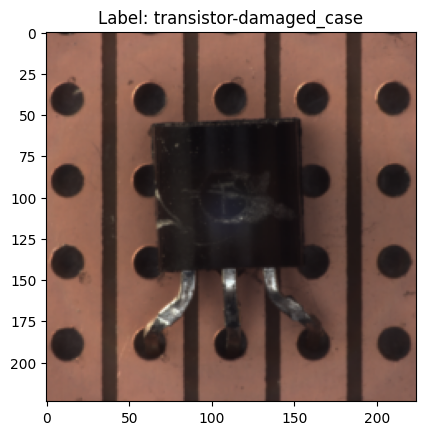

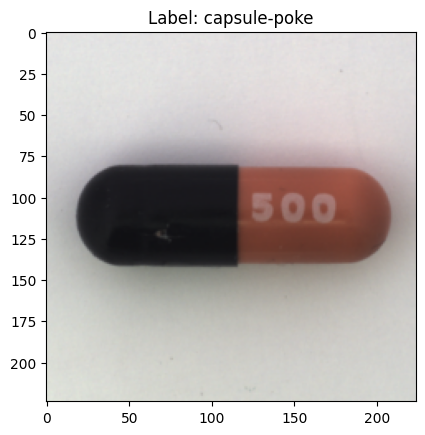

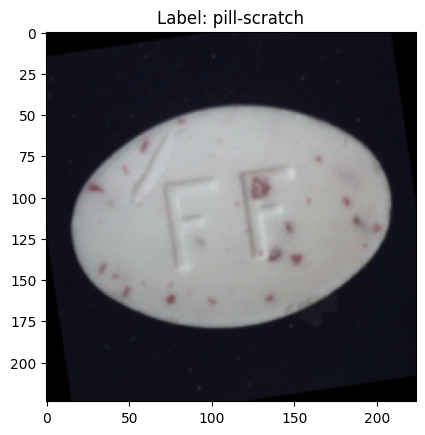

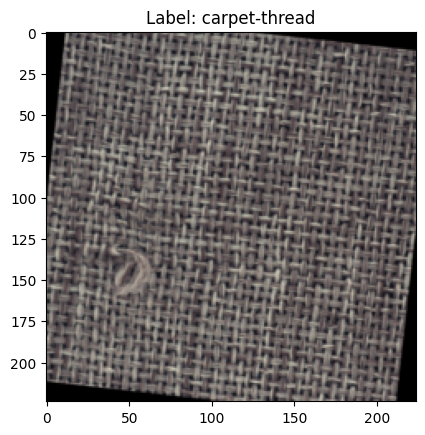

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 로더에서 한 배치만 가져옵니다.
images, labels = next(iter(train_loader))
class_name_list = train_dataset.classes

# 이미지와 레이블 확인
for i in range(batch_size):
    image = images[i]  # 이미지
    label = labels[i].item()  # 레이블

    # 이미지를 시각화합니다.
    image = image.numpy().transpose((1, 2, 0))  # 이미지 차원을 (C, H, W)에서 (H, W, C)로 변경
    image = np.clip(image, 0, 1)  # 픽셀 값 범위를 [0, 1]로 조정
    plt.imshow(image)
    plt.title(f"Label: {class_name_list[label]}")
    plt.show()


In [6]:
import os
import csv

# 모델 저장 경로 설정
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
best_model_path = os.path.join(checkpoint_dir, "best_model.pth")

def save_metrics_to_csv(train_losses, val_losses, train_accuracies, val_accuracies, filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Val_Loss', 'Train_Acc', 'Val_Acc'])
        for epoch, (train_loss, val_loss, train_acc, val_acc) in enumerate(zip(train_losses, val_losses, train_accuracies, val_accuracies), 1):
            writer.writerow([epoch, train_loss, val_loss, train_acc, val_acc])
    print(f"Metrics saved to {filename}")

# 학습 함수 정의
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, save_interval=1, patience=5, filename='train_metrics.csv'):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_accuracy = 0.0  # 가장 높은 검증 정확도 초기화
    early_stopping_counter = 0  # 조기 종료 카운터 초기화
    best_val_loss = float('inf')  # 가장 낮은 검증 손실 초기화
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            # 각 미니배치의 손실 및 정확도 표시
            train_loss = running_loss / total_train
            train_accuracy = correct_train / total_train
            pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        
        # 검증 데이터로 정확도 측정
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_pbar = tqdm(enumerate(val_loader), total=len(val_loader))  # 검증 데이터에 대한 tqdm 설정
        with torch.no_grad():
            for j, (inputs, labels) in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
                # 검증 데이터의 손실 및 정확도 표시
                val_loss_avg = val_loss / total_val
                val_accuracy = correct_val / total_val
                val_pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss_avg:.4f}, Val Acc: {val_accuracy:.4f}")
        
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct_val / total_val
        
        # 손실과 정확도 기록
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # 가장 높은 검증 정확도를 가진 모델을 저장
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at: {best_model_path}")
            early_stopping_counter = 0  # 조기 종료 카운터 초기화
        else:
            early_stopping_counter += 1  # 조기 종료 카운터 증가
        
        # 검증 손실이 감소하지 않으면 조기 종료
        if val_loss >= best_val_loss:
            early_stopping_counter += 1
        else:
            best_val_loss = val_loss
            early_stopping_counter = 0
        
        if early_stopping_counter >= patience:
            print("Early stopping triggered. Training terminated.")
            break
        
        # 주기적으로 메트릭스를 저장
        if (epoch + 1) % save_interval == 0:
            save_metrics_to_csv(train_losses, val_losses, train_accuracies, val_accuracies, filename)
    
    # 학습 결과 반환
    return train_losses, val_losses, train_accuracies, val_accuracies


In [7]:
# 학습 실행
train_losses, val_losses, train_accuracies, val_accuracies = train_model(vgg16, criterion, optimizer, train_loader, val_loader, num_epochs=10, patience=5, save_interval=1, filename='train_metrics.csv')

Epoch [1/10], Train Loss: 2.4906, Train Acc: 0.3049: 100%|██████████| 625/625 [06:59<00:00,  1.49it/s]
Epoch [1/10], Val Loss: 1.5634, Val Acc: 0.4120: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [1/10], Train Loss: 2.4906, Val Loss: 1.5634, Train Acc: 0.3049, Val Acc: 0.4120
Best model saved at: checkpoints/best_model.pth
Metrics saved to train_metrics.csv


Epoch [2/10], Train Loss: 1.5076, Train Acc: 0.4498: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [2/10], Val Loss: 1.2305, Val Acc: 0.5506: 100%|██████████| 107/107 [01:06<00:00,  1.62it/s]


Epoch [2/10], Train Loss: 1.5076, Val Loss: 1.2305, Train Acc: 0.4498, Val Acc: 0.5506
Best model saved at: checkpoints/best_model.pth
Metrics saved to train_metrics.csv


Epoch [3/10], Train Loss: 1.2482, Train Acc: 0.5375: 100%|██████████| 625/625 [06:52<00:00,  1.52it/s]
Epoch [3/10], Val Loss: 1.1298, Val Acc: 0.5833: 100%|██████████| 107/107 [01:05<00:00,  1.62it/s]


Epoch [3/10], Train Loss: 1.2482, Val Loss: 1.1298, Train Acc: 0.5375, Val Acc: 0.5833
Best model saved at: checkpoints/best_model.pth
Metrics saved to train_metrics.csv


Epoch [4/10], Train Loss: 1.0717, Train Acc: 0.6030: 100%|██████████| 625/625 [06:51<00:00,  1.52it/s]
Epoch [4/10], Val Loss: 0.9363, Val Acc: 0.6692: 100%|██████████| 107/107 [01:06<00:00,  1.60it/s]


Epoch [4/10], Train Loss: 1.0717, Val Loss: 0.9363, Train Acc: 0.6030, Val Acc: 0.6692
Best model saved at: checkpoints/best_model.pth
Metrics saved to train_metrics.csv


Epoch [5/10], Train Loss: 0.9212, Train Acc: 0.6693: 100%|██████████| 625/625 [06:52<00:00,  1.52it/s]
Epoch [5/10], Val Loss: 0.8179, Val Acc: 0.6996: 100%|██████████| 107/107 [01:06<00:00,  1.60it/s]


Epoch [5/10], Train Loss: 0.9212, Val Loss: 0.8179, Train Acc: 0.6693, Val Acc: 0.6996
Best model saved at: checkpoints/best_model.pth
Metrics saved to train_metrics.csv


Epoch [6/10], Train Loss: 0.8110, Train Acc: 0.7046: 100%|██████████| 625/625 [06:50<00:00,  1.52it/s]
Epoch [6/10], Val Loss: 0.7283, Val Acc: 0.7376: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [6/10], Train Loss: 0.8110, Val Loss: 0.7283, Train Acc: 0.7046, Val Acc: 0.7376
Best model saved at: checkpoints/best_model.pth
Metrics saved to train_metrics.csv


Epoch [7/10], Train Loss: 0.7067, Train Acc: 0.7461: 100%|██████████| 625/625 [06:51<00:00,  1.52it/s]
Epoch [7/10], Val Loss: 0.6487, Val Acc: 0.7639: 100%|██████████| 107/107 [01:06<00:00,  1.60it/s]


Epoch [7/10], Train Loss: 0.7067, Val Loss: 0.6487, Train Acc: 0.7461, Val Acc: 0.7639
Best model saved at: checkpoints/best_model.pth
Metrics saved to train_metrics.csv


Epoch [8/10], Train Loss: 0.6367, Train Acc: 0.7706: 100%|██████████| 625/625 [06:50<00:00,  1.52it/s]
Epoch [8/10], Val Loss: 0.6623, Val Acc: 0.7545: 100%|██████████| 107/107 [01:06<00:00,  1.62it/s]


Epoch [8/10], Train Loss: 0.6367, Val Loss: 0.6623, Train Acc: 0.7706, Val Acc: 0.7545
Metrics saved to train_metrics.csv


Epoch [9/10], Train Loss: 0.5689, Train Acc: 0.8023: 100%|██████████| 625/625 [06:55<00:00,  1.50it/s]
Epoch [9/10], Val Loss: 0.5959, Val Acc: 0.7878: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [9/10], Train Loss: 0.5689, Val Loss: 0.5959, Train Acc: 0.8023, Val Acc: 0.7878
Best model saved at: checkpoints/best_model.pth
Metrics saved to train_metrics.csv


Epoch [10/10], Train Loss: 0.5117, Train Acc: 0.8197: 100%|██████████| 625/625 [06:58<00:00,  1.49it/s]
Epoch [10/10], Val Loss: 0.5412, Val Acc: 0.8130: 100%|██████████| 107/107 [01:07<00:00,  1.59it/s]


Epoch [10/10], Train Loss: 0.5117, Val Loss: 0.5412, Train Acc: 0.8197, Val Acc: 0.8130
Best model saved at: checkpoints/best_model.pth
Metrics saved to train_metrics.csv


## Training Results

In [11]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracies(train_accuracies, val_accuracies):
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

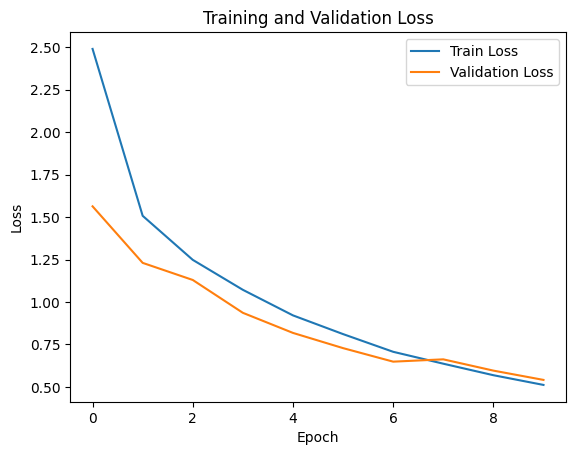

In [12]:
plot_losses(train_losses, val_losses)

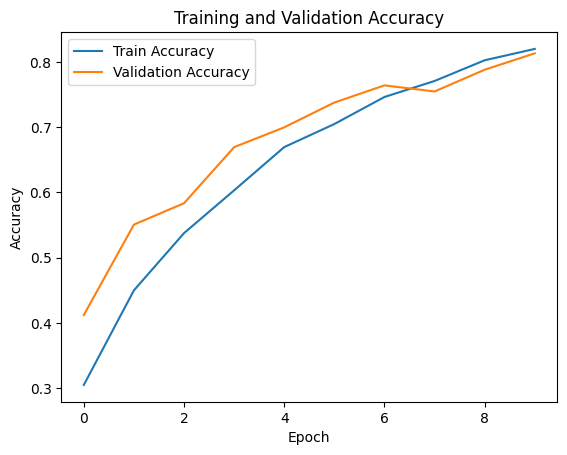

In [13]:
plot_accuracies(train_accuracies, val_accuracies)